In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

import d2l

Mounted at /content/gdrive


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# **Modern Convolutional Neural Networks - AlexNet, LeNet-5 (Chapter 8)**

# 1. AlexNet may be too complex for the Fashion-MNIST dataset, in particular due to the low resolution of the initial images. Try simplifying the model to make the training faster, while ensuring that the accuracy does not drop significantly. Design a better model that works directly on 28 x 28 images.

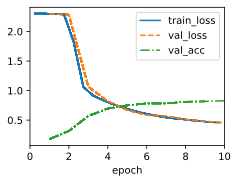

In [ ]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)
# Takes ~9 minutes

Let's modify the model and simplify it.

Implementing the following changes:
1. Halving the number of output channels in each convolutional layer except for the first.
2. Halving the number of neurons in each fully connected layer.
3. Remove dropout layers
4. Increasing the learning rate to 0.05.
5. Removing the 224x224 resizing argument from the data.

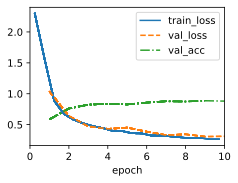

In [ ]:
class AlexNetSimple(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(128, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(1024), nn.ReLU(),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

model = AlexNetSimple(lr=0.05)
data = d2l.FashionMNIST(batch_size=128, resize=(28,28))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

As shown above, these changes create much quicker convergence and the model runs ~4x faster (2 minutes compared to 9). Accuracy improves(or at least does not drop significantly) in this model as well.

# 2. Apply dropout and ReLU to LeNet-5. Does it improve? Can you improve things further by preprocessing to take advantage of the invariances inherent in the images?

First recall LeNet-5's original accuracy below.

In [ ]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))


In [ ]:

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

The above took ~2 minutes to run and seems to reach about 80% accuracy.

Now let's implement the following changes:
1. Simoids converted to ReLUs
2. AvgPools switched to MaxPools.
3. Dropouts Added


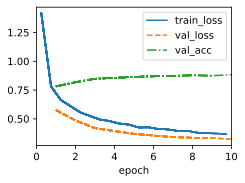

In [ ]:
class LeNetModified(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(84), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))

trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNetModified(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

Immediately the model improves significantly - the accuracy starts at 80% and improves to ~90%. The model takes almost the exact same time to run as well.

# 3. Compare the learning rates for LeNet with and without batch normalization. Plot the increase in validation accuracy. How large can you make the learning rate before the optimization fails in both cases?

In [ ]:
# Using Batch normalization

class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

def stat_model_acc(model, data):
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
    trainer.fit(model, data)
    X,y = next(iter(data.get_dataloader(False)))
    X = X.to('cuda')
    y = y.to('cuda')
    y_hat = model(X)
    return model.accuracy(y_hat,y).item()

data = d2l.FashionMNIST(batch_size=128)
lr_list = [0.001,0.01,0.03,0.1,0.3]
le_accs= []
ble_accs = []
for lr in lr_list:#[:1]:
    le = LeNet(lr=lr)
    ble = BNLeNet(lr=lr)
    le_accs.append(stat_model_acc(le, data))
    ble_accs.append(stat_model_acc(ble, data))

# Takes ~22 min to run

In [ ]:
lr_list2 = [1.0, 3.0, 10., 30.]
for lr in lr_list2:#[:1]:
    le = LeNet(lr=lr)
    ble = BNLeNet(lr=lr)
    le_accs.append(stat_model_acc(le, data))
    ble_accs.append(stat_model_acc(ble, data))

In [ ]:
lr_list3 = [100, 300]
for lr in lr_list3:#[:1]:
    le = LeNet(lr=lr)
    ble = BNLeNet(lr=lr)
    le_accs.append(stat_model_acc(le, data))
    ble_accs.append(stat_model_acc(ble, data))


print(le_accs)
print(ble_accs)

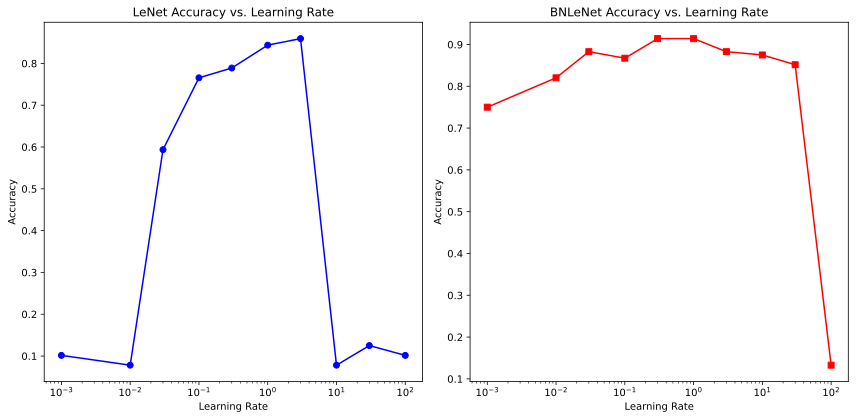

In [ ]:
import matplotlib.pyplot as plt

lr_listfull = [0.001,0.01,0.03,0.1,0.3, 1, 3, 10, 30, 100]
# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot for LeNet
axs[0].semilogx(lr_listfull, le_accs[:-1], marker='o', color='b')
axs[0].set_title('LeNet Accuracy vs. Learning Rate')
axs[0].set_xlabel('Learning Rate')
axs[0].set_ylabel('Accuracy')

# Plot for BNLeNet
axs[1].semilogx(lr_listfull, ble_accs[:-1], marker='s', color='r')
axs[1].set_title('BNLeNet Accuracy vs. Learning Rate')
axs[1].set_xlabel('Learning Rate')
axs[1].set_ylabel('Accuracy')

# Show plots
plt.tight_layout()
plt.show()

Here we can see that LeNet's accuracy (no batch normalization) begins to falter at 0.1 and higher, while BLeNet maintains its accuracy up to learning rate of 30 before failing. Very impressive!